> the initial estimates:
mu = 216.16865959569043
sig = 27.467928699504167
a = 590.5487158469946

> the final fitted estimates:
mu = 229.24231151323912 ± 0.17573318327605753
sig = 7.087021140271912 ± 0.17573318620961006
a = 435.6932378742273 ± 9.356157982589373
Peak counts: 24.526024465387607

y = 3.87996 * x + -1.98439


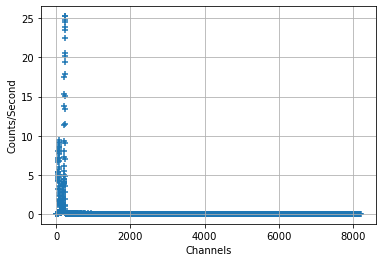

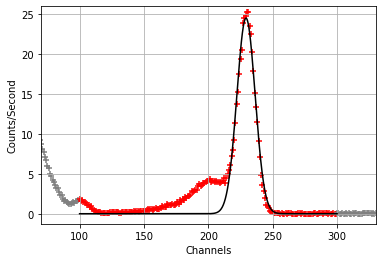

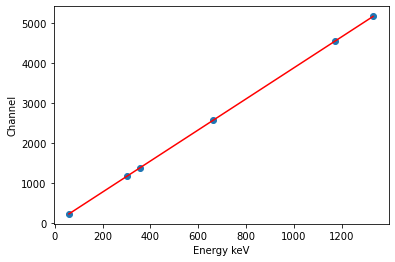

C:\Users\marti\AppData\Local\Temp\ipykernel_10536\2623693425.py:281: RuntimeWarning: invalid value encountered in sqrt
  return (np.sqrt(R_2))


R2 = 283.90667 * E-2 + -0.09171 * E-1 + 0.00006


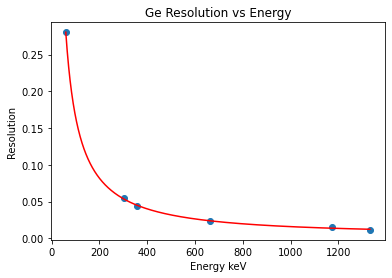

Ei = 0.00002 + -0.00000 * log(E) + 0.00000 * (log(E))^2


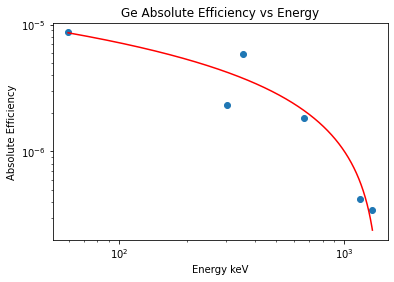

Ei = 0.00512 + -0.00073 * log(E) + 0.00000 * (log(E))^2


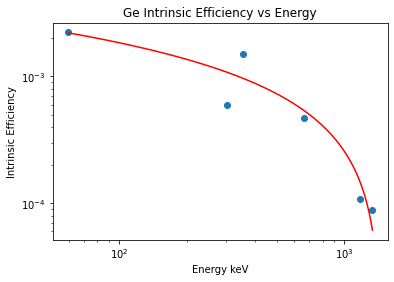

In [3]:

import numpy as np
import matplotlib.pyplot as plt
import pathlib
from scipy.optimize import curve_fit
from numpy import inf as INF

# folder path
dir_path = r"C:\Users\Home\Desktop\Lab Data Master\Ge Detector 0"

# to store file names
res = []

# construct path object
d = pathlib.Path(dir_path)

# iterate directory
for entry in d.iterdir():
    # check if it a file
    if entry.is_file():
        res.append(entry)
        
CHANNELS = np.array(list(range(8192)))
BACKGROUND = (np.genfromtxt(res[0],skip_header=12,skip_footer=17)/1200)

def Isotope_Choice(x):
    if x == 1:
        COUNTS = abs(((np.genfromtxt(res[1],skip_header=12,skip_footer=17))/1212))
        Roi_Start = 4500
        Roi_End = 4600
        Roi_Start_2 = 5130
        Roi_End_2 = 5210 
        Top = 0.04
    if x == 2: 
        COUNTS = abs(((np.genfromtxt(res[2],skip_header=12,skip_footer=17))/122) - BACKGROUND)
        Roi_Start = 100
        Roi_End = 300
        Roi_Start_2 = 0
        Roi_End_2 = 0
        Top = 26
    if x == 3: 
        COUNTS = abs(((np.genfromtxt(res[3],skip_header=12,skip_footer=17))/121) - BACKGROUND)
        Roi_Start = 1150
        Roi_End = 1200
        Roi_Start_2 =1350
        Roi_End_2 = 1400
        Top = 1.2
    if x == 4:
        COUNTS = abs(((np.genfromtxt(res[4],skip_header=12,skip_footer=17))/300) - BACKGROUND)
        Roi_Start = 2450
        Roi_End = 2590
        Roi_Start_2 = 0
        Roi_End_2 = 0
        Top = 6
    return (COUNTS, Roi_Start, Roi_End, Roi_Start_2, Roi_End_2, Top)

#Am:res[2]
#Ba:res[3]
#Co:res[1]
#Cs:res[4]

COUNTS,Roi_Start, Roi_End, Roi_Start_2, Roi_End_2, Top = Isotope_Choice(2)

def plot_spectrum(ax, channels, counts, 
                  xlabel='Channels', ylabel='Counts/Second', 
                  **kwargs):
    """Helper function to plot spectra."""
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)

    return ax.scatter(channels, counts, **kwargs)


TWO_PI = np.pi * 2.

def gaussian(x, mu, sig, a):
    return a * np.exp(-0.5 * (x-mu)**2 / sig**2) / np.sqrt(TWO_PI * sig**2)

def double_gaussian(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gaussian(x, mu1, sigma1, A1) + gaussian(x, mu2, sigma2, A2)

def in_interval(x, xmin=-INF, xmax=INF):
    """Boolean mask with value True for x in [xmin, xmax) ."""
    _x = np.asarray(x)
    return np.logical_and(xmin <= _x, _x < xmax) 

def filter_in_interval(x, y, xmin, xmax):
    """Selects only elements of x and y where xmin <= x < xmax."""
    _mask = in_interval(x, xmin, xmax)
    return [np.asarray(x)[_mask] for x in (x, y)]

def colourmask(x, xmin=-INF, xmax=INF, cin='red', cout='gray'):
    """Colour cin if within region of interest, cout otherwise."""
    # compute mask as integers 0 or 1
    _mask = np.array(in_interval(x, xmin, xmax), dtype=int)

    # convert to colours
    colourmap = np.array([cout, cin])
    return colourmap[_mask]

def simple_model_fit(model, channels, counts, roi, **kwargs):
    """Least squares estimate of model parameters."""
    # select relevant channels & counts
    _channels, _counts = filter_in_interval(channels, counts, *roi)
    
    # fit the model to the data
    popt, pcov = curve_fit(model, _channels, _counts, **kwargs)
    return popt, pcov

def format_result(params, popt, pcov):
    """Display parameter best estimates and uncertainties."""
    # extract the uncertainties from the covariance matrix
    perr = np.sqrt(np.diag(pcov))
    
    # format parameters with best estimates and uncertainties 
    _lines = (f"{p} = {o} ± {e}" for p, o, e in zip(params, popt, perr))
    return "\n".join(_lines)

def plot_model(ax, model, xrange, ps, npoints=1001, **kwargs):
    """Plots a 1d model on an Axes smoothly over xrange."""
    _channels = np.linspace(*xrange, npoints)
    _counts   = model(_channels, *ps)
    
    return ax.plot(_channels, _counts, **kwargs)

def first_moment(x, y):
    return np.sum(x * y) / np.sum(y)
    
def second_moment(x, y):
    x0 = first_moment(x, y)
    return np.sum((x-x0)**2 * y) / np.sum(y)

def gaussian_initial_estimates(channels, counts):
    """Estimates of the three parameters of the gaussian distribution."""
    mu0 = first_moment(channels, counts)
    sig0 = np.sqrt(second_moment(channels, counts))
    a0 = np.sum(counts)
    
    return (mu0, sig0, a0)


def plot_single(x, y, z):

    GAUSSIAN_PARAMS = ('mu', 'sig', 'a')
    ROI = (x, y)

    # make initial estimates
    _channels, _counts = filter_in_interval(CHANNELS, COUNTS, *ROI)
    _p0 = gaussian_initial_estimates(_channels, _counts)

    # show the initial guesses
    print("> the initial estimates:")
    print("\n".join(f"{p} = {o}" for p, o in zip(GAUSSIAN_PARAMS, _p0)))

    # do the fit
    popt, pcov = simple_model_fit(gaussian, CHANNELS, COUNTS, ROI, p0=_p0)

    # display result
    print("\n> the final fitted estimates:")
    print(format_result(GAUSSIAN_PARAMS, popt, pcov))

    fig, ax = plt.subplots(1)
    colours = colourmask(CHANNELS, xmin=x, xmax=y)

    # plot the data, showing the ROI 
    plot_spectrum(ax, CHANNELS, COUNTS, c=colours, marker='+')

    # plot the model with its parameters
    plot_model(ax, gaussian, (x, y), popt, c='k')
    # puts a limit on the range of x (Chanels)
    plt.xlim(x-30,y+30)
    plt.ylim(top=z)
    print("Peak counts:",gaussian(popt[0], popt[0], popt[1], popt[2]))
    
def plot_double(x1, y1, x2, y2, z):

    GAUSSIAN_PARAMS = ('mu', 'sig', 'a')
    ROI_1 = (x1, y1)
    ROI_2 = (x2, y2)

    # make initial estimates
    _channels, _counts = filter_in_interval(CHANNELS, COUNTS, *ROI_1)
    _p0 = gaussian_initial_estimates(_channels, _counts)

    # show the initial guesses
    print("> the initial estimates:")
    print("\n".join(f"{p} = {o}" for p, o in zip(GAUSSIAN_PARAMS, _p0)))

    # do the fit
    popt, pcov = simple_model_fit(gaussian, CHANNELS, COUNTS, ROI_1, p0=_p0)

    # display result
    print("> the final fitted estimates:")
    print(format_result(GAUSSIAN_PARAMS, popt, pcov))

    fig, ax = plt.subplots(1)
    colours = colourmask(CHANNELS, xmin=x1, xmax=y2)

    # plot the data, showing the ROI 
    plot_spectrum(ax, CHANNELS, COUNTS, c=colours, marker='+')

    # plot the model with its parameters
    plot_model(ax, gaussian, (x1, y1), popt, c='k')
    # puts a limit on the range of x (Chanels)
    plt.xlim(x1-30,y2+30)
    plt.ylim(top=z)
    print("Peak counts 1:",gaussian(popt[0], popt[0], popt[1], popt[2]))
    
    _channels, _counts = filter_in_interval(CHANNELS, COUNTS, *ROI_2)
    _p0 = gaussian_initial_estimates(_channels, _counts)

    # show the initial guesses
    print("> the initial estimates:")
    print("\n".join(f"{p} = {o}" for p, o in zip(GAUSSIAN_PARAMS, _p0)))

    # do the fit
    popt, pcov = simple_model_fit(gaussian, CHANNELS, COUNTS, ROI_2, p0=_p0)

    # display result
    print("\n> the final fitted estimates:")
    print(format_result(GAUSSIAN_PARAMS, popt, pcov))
    
    plot_model(ax, gaussian, (x2, y2), popt, c='k')
    print("Peak counts 2:",gaussian(popt[0], popt[0], popt[1], popt[2]))

#Used to view the full spectrum and find ROI
fig, ax = plt.subplots(1)
plot_spectrum(ax, CHANNELS, COUNTS,  marker='+')
#plt.xlim(0,3000)
#plt.ylim(0,0.1)
plt.savefig('Ge_Co_Full_Spe') 

#choose what type of gaussian
    
if Top < 2:
    plot_double(Roi_Start, Roi_End, Roi_Start_2, Roi_End_2, Top)
    
else:
    plot_single(Roi_Start, Roi_End, Top)
    
plt.savefig('Ge_Co_Peak')  

#x = values of E, y = channel number
x = (1173.228,1332.492,59.5409,302.8508,356.0129,661.657)
y = (4549.4146,5168.7080,229.2423,1172.9074,1379.4499,2565.0495)
# define the true objective function

def line(x, a, b):
	return a * x + b

popt, _ = curve_fit(line, x, y)
# summarize the parameter values
a, b = popt
print('\ny = %.5f * x + %.5f' % (a, b))
# plot input vs output
fig, ax = plt.subplots(1)
plt.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = np.arange(min(x), max(x), 1)
# calculate the output for the range
y_line = line(x_line, a, b)
# create a line plot for the mapping function
plt.plot(x_line, y_line, '-', color='red')
ax.set_xlabel('Energy keV')
ax.set_ylabel('Channel')
plt.savefig('Ge_Calibration_Curve') 
plt.show()



sigma_values = [7.498550,6.481606,7.08702,7.1091,6.56422,6.58638]

FWHM = [item * 2.355 for item in sigma_values]

Resolution = [i / j for i, j in zip(FWHM,x)]

R_Squared = [i*i for i in (Resolution)]

def resolution_eqn(E, a, b, c):
    R_2 = a*(E**-2) + b*(E**-1) + c
    return (np.sqrt(R_2))

fit, _ = curve_fit(resolution_eqn, x, Resolution)
a,b,c = fit
print('R2 = %.5f * E-2 + %.5f * E-1 + %.5f' % (a, b, c))
fig, ax = plt.subplots(1)
plt.scatter(x, Resolution)
#plt.xscale("log")
#plt.yscale("log")
x_line = np.arange(min(x), max(x), 1)
# calculate the output for the range
y_line = resolution_eqn(x_line, a, b, c)
# create a line plot for the mapping function
plt.plot(x_line, y_line, '-', color='red')
ax.set_xlabel('Energy keV')
ax.set_ylabel('Resolution')
plt.title('Ge Resolution vs Energy')
plt.savefig('Ge_Resolution') 
plt.show()

#half life for am,cs,co and ba in seconds
lam_ary = []
half_life = [13631588000, 949038600 ,166259956, 332336980]
for x in range(4):
    lam = 0.693/half_life[x]
    lam_ary.append(lam)

#time elapsed
t_Ge = [1353470106, 1378091203, 1378087276, 1378084407]  #am ba cs co

#activity of lab 2 sources
A_am2 = 37000*11.92*np.exp(-lam_ary[0]*t_Ge[0])*122
A_cs2 = 37000*12.41*np.exp(-lam_ary[1]*t_Ge[2])*300
A_co2 = 37000*11.32*np.exp(-lam_ary[2]*t_Ge[3])*1212
A_ba2 = 37000*10.82*np.exp(-lam_ary[3]*t_Ge[1])*121

#values for area under curve of each peak
all_a = [435.6932379, 6.373647192, 16.11229915, 0.686710905, 0.560327351, 92.98438787]
all_Ac = [A_am2, A_ba2, A_ba2, A_co2, A_co2,  A_cs2]
FEPE = []
for x in range(6):
    result = all_a[x]/all_Ac[x]
    FEPE.append(result)

x = (59.5409, 302.8508, 356.02, 1173.228, 1332.492, 661.657)

def efficency_eqn(E, a, b, c):
    Eff = a + b*np.log(E) + c*(np.log(E))**2
    return (Eff)
fit, _ = curve_fit(efficency_eqn, x, FEPE)
a,b,c = fit
print('Ei = %.5f + %.5f * log(E) + %.5f * (log(E))^2' % (a, b, c))
fig, ax = plt.subplots(1)
plt.scatter(x, FEPE)
#plt.xscale("log")
#plt.yscale("log")
x_line = np.arange(min(x), max(x), 1)
# calculate the output for the range
y_line = efficency_eqn(x_line, a, b, c)
# create a line plot for the mapping function
plt.plot(x_line, y_line, '-', color='red')
ax.set_xlabel('Energy keV')
ax.set_ylabel('Absolute Efficiency')
plt.xscale("log")
plt.yscale("log")
plt.title('Ge Absolute Efficiency vs Energy')
plt.savefig('Ge_Absolute_Efficiency')
plt.show()

radius = 0.025
length = 0.06
distance = 0.2

area_of_detector = ((np.pi*radius**2)*abs(np.cos(0)) + 2*radius*length*abs(np.sin(0)))
geo_factor = area_of_detector/(4*np.pi*distance**2) 

intrinsic_Eff = FEPE/geo_factor

fit, _ = curve_fit(efficency_eqn, x, intrinsic_Eff)
a,b,c = fit
print('Ei = %.5f + %.5f * log(E) + %.5f * (log(E))^2' % (a, b, c))
fig, ax = plt.subplots(1)
plt.scatter(x, intrinsic_Eff) 
#plt.xscale("log")
#plt.yscale("log")
x_line = np.arange(min(x), max(x), 1)
# calculate the output for the range
y_line = efficency_eqn(x_line, a, b, c)
# create a line plot for the mapping function
plt.plot(x_line, y_line, '-', color='red')
ax.set_xlabel('Energy keV')
ax.set_ylabel('Intrinsic Efficiency')
plt.xscale("log")
plt.yscale("log")
plt.title('Ge Intrinsic Efficiency vs Energy')
plt.savefig('Ge_Intrinsic Efficiency')
plt.show()